## Jupyter notebook to demonstrate the basic calibration setup

This notebook runs the following tasks:
* Create a test Visibility dataset.
   * Not adding visibility sample noise. Just testing that things are working exactly as expected.
   * Using the GLEAM sky model and a common everybeam station beam model.
   * Add complex Gaussian noise corruptions to station gains and leakage.
   * Impose a wavelength^2-dependent rotate on each station Jones matrix 
* Predict model visibilities (using GLEAM and everybeam).
* Do polarised bandpass calibration.
* Fit for the wavelength^2-dependent rotation of each station.
* Redo polarised bandpass calibration.
* Use dask to handle processing of different frequency sub-bands.

This notebook requires:
* See imports.

In [1]:
# Demonstration of basic calibration

# pylint cannot seem to handle astropy units
# pylint: disable=no-member

import logging
import sys
import time as timer

# Imports
import warnings

import numpy as np
from astropy import constants as const
from astropy import units
from astropy.coordinates import Angle, SkyCoord
from dask.distributed import Client, LocalCluster

# from ska_sdp_func_python.calibration.operations import apply_gaintable
from ska_sdp_datamodels.calibration.calibration_create import (
    create_gaintable_from_visibility,
)
from ska_sdp_datamodels.configuration.config_create import (
    create_named_configuration,
)
from ska_sdp_datamodels.science_data_model import PolarisationFrame
from ska_sdp_datamodels.visibility.vis_create import create_visibility
from ska_sdp_datamodels.visibility.vis_io_ms import export_visibility_to_ms

from ska_sdp_instrumental_calibration.data_managers.dask_wrappers import (
    load_ms,
    predict_vis,
    run_solver,
)
from ska_sdp_instrumental_calibration.processing_tasks.calibration import (
    apply_gaintable,
)
from ska_sdp_instrumental_calibration.processing_tasks.lsm import (
    convert_model_to_skycomponents,
    generate_lsm,
)
from ska_sdp_instrumental_calibration.processing_tasks.post_processing import (
    model_rotations,
)
from ska_sdp_instrumental_calibration.processing_tasks.predict import (
    predict_from_components,
)

warnings.simplefilter(action="ignore", category=FutureWarning)

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__


In [2]:
t0 = timer.perf_counter()

In [3]:
# Set up a local dask cluster and client

cluster = LocalCluster()
client = Client(cluster)

In [4]:
# Create a test Visibility dataset

# -------------------------------------------------------------------------- #
# Set up the array

# Read in an array configuration
low_config = create_named_configuration("LOWBD2")

# Down-select to a desired sub-array
#  - ECP-240228 modified AA2 clusters:
#      Southern Arm: S8 (x6), S9, S10 (x6), S13, S15, S16
#      Northern Arm: N8, N9, N10, N13, N15, N16
#      Eastern Arm: E8, E9, E10, E13.
#  - Most include only 4 of 6 stations, so just use the first 4:
AA2 = (
    np.concatenate(
        (
            345 + np.arange(6),  # S8-1:6
            351 + np.arange(4),  # S9-1:4
            429 + np.arange(6),  # S10-1:6
            447 + np.arange(4),  # S13-1:4
            459 + np.arange(4),  # S15-1:4
            465 + np.arange(4),  # S16-1:4
            375 + np.arange(4),  # N8-1:4
            381 + np.arange(4),  # N9-1:4
            471 + np.arange(4),  # N10-1:4
            489 + np.arange(4),  # N13-1:4
            501 + np.arange(4),  # N15-1:4
            507 + np.arange(4),  # N16-1:4
            315 + np.arange(4),  # E8-1:4
            321 + np.arange(4),  # E9-1:4
            387 + np.arange(4),  # E10-1:4
            405 + np.arange(4),  # E13-1:4
        )
    )
    - 1
)
mask = np.isin(low_config.id.data, AA2)
nstations = low_config.stations.shape[0]
low_config = low_config.sel(indexers={"id": np.arange(nstations)[mask]})

# Reset relevant station parameters
nstations = low_config.stations.shape[0]
low_config.stations.data = np.arange(nstations).astype("str")
low_config = low_config.assign_coords(id=np.arange(nstations))
# low_config.attrs["name"] = low_config.name+"-AA2"
low_config.attrs["name"] = "AA2-Low-ECP-240228"

print(f"Using {low_config.name} with {nstations} stations")

# -------------------------------------------------------------------------- #
# Set up the observation

# Set the phase centre in the ICRS coordinate frame
ra0 = Angle(0.0 * units.hourangle)
dec0 = Angle(-27.0 * units.deg)

# Set the parameters of sky model components
# chanwidth = 400e6 / 512  # station/CBF coarse channels = 781.25 kHz
chanwidth = 781.25e3  # Hz
nfrequency = 96
frequency = 781.25e3 * 128 + chanwidth * np.arange(nfrequency)
sample_time = 0.9  # seconds
solution_interval = sample_time  # would normally be minutes

# Set the phase centre hour angle range for the sim (in radians)
ha0 = 1 * np.pi / 12  # radians
ha = ha0 + np.arange(0, solution_interval, sample_time) / 3600 * np.pi / 12

# Create the Visibility dataset
vis = create_visibility(
    low_config,
    ha,
    frequency,
    channel_bandwidth=[chanwidth] * len(frequency),
    polarisation_frame=PolarisationFrame("linear"),
    phasecentre=SkyCoord(ra=ra0, dec=dec0),
    weight=1.0,
)

# Generate a true sky model and true visibilties for the whole band
gleamfile = "/data/EOS_1/mit183/gleamegc.dat"
fov = 10.0
flux_limit = 1
tsm = generate_lsm(
    gleamfile=gleamfile,
    phasecentre=vis.phasecentre,
    fov=fov,
    flux_limit=flux_limit,
)

eb_ms = "/data/EOS_1/mit183/SKA/SP-4626/OSKAR_MOCK.ms"
eb_coeffs = "/data/EOS_1/mit183/SKA/SP-4626/ska-sdp-func-everybeam/coeffs"

tsm_components = convert_model_to_skycomponents(tsm, vis.frequency.data)
predict_from_components(vis, tsm_components, eb_coeffs=eb_coeffs, eb_ms=eb_ms)

# Initially Jones matrices are 2x2 identity matrices
jones = create_gaintable_from_visibility(
    vis, jones_type="B", timeslice=solution_interval
)

np.random.seed(int(1e8))

# Add random complex antenna gain and leakage variations to the Jones matrices
g_sigma = 0.05
jones.gain.data += (
    np.random.normal(0, g_sigma, jones.gain.shape)
    + np.random.normal(0, g_sigma, jones.gain.shape) * 1j
)

# Multiply by ionospheric Faraday rotation
#  - Todo: rotate each component and each 5.4kHz channel separately
#  - Todo: use a phase screen. For now just have a gradient across the array
x = low_config.xyz.data[:, 0]
pp_rm = 1 + 4 * (x - np.min(x)) / (np.max(x) - np.min(x))
fr_mat = np.zeros((nstations, nfrequency, 2, 2))
lambda_sq = (const.c.value / frequency) ** 2
for stn in range(nstations):
    d_pa = pp_rm[stn] * lambda_sq
    fr_mat[stn] = np.stack(
        (np.cos(d_pa), -np.sin(d_pa), np.sin(d_pa), np.cos(d_pa)),
        axis=1,
    ).reshape(-1, 2, 2)
tmp = jones.gain.data.copy()
jones.gain.data = np.einsum("tsfpx,sfxq->tsfpq", tmp, fr_mat)

vis = apply_gaintable(vis=vis, gt=jones, inverse=False)

# Save a copy for final checks
vis_numpy = vis.copy(deep=True)

# Export vis to a file
ms_name = "demo.ms"
export_visibility_to_ms(ms_name, [vis])

vis = None

Using AA2-Low-ECP-240228 with 68 stations


2024-12-09 10:36:46,714 - processing_tasks.lsm - INFO - extracted 37 GLEAM components


extracted 37 GLEAM components


2024-12-09 10:36:46,748 - processing_tasks.predict - INFO - Using EveryBeam model in predict


Using EveryBeam model in predict
Initialising beams for Low
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 101 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 102 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 104 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 105 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 106 MHz, using the nearest neighbor with frequency 110 MHz instead
Coul

In [5]:
# Do pre-processing

# Set the number of channels in each frequency chunk
fchunk = nfrequency // 4

# Read in the Visibility dataset in chunks
vis = load_ms(ms_name, fchunk)

# Get the LSM (single call for all channels / dask tasks)
lsm = generate_lsm(
    gleamfile=gleamfile,
    phasecentre=vis_numpy.phasecentre,
    fov=fov,
    flux_limit=flux_limit,
)

# Adapative RFI flagging is flagging too much
# (perhaps due to the rotations)

Reading uni. fields [0], uni. data descs [0]


2024-12-09 10:36:54,634 - processing_tasks.lsm - INFO - extracted 37 GLEAM components


extracted 37 GLEAM components


In [6]:
# Predict model visibilities

modelvis = predict_vis(vis, lsm, eb_ms=eb_ms, eb_coeffs=eb_coeffs)

# This avoid regeneration, if we can be sure it's okay
# vis = vis.persist()
# modelvis = modelvis.persist()

# Make sure modelvis was updated
# This triggers an extra load, but but is worth checking
# assert np.all(modelvis.vis.data != 0), "modelvis should have changed"

In [7]:
# Do the bandpass calibration

# Load all of the solutions into a numpy array for full-band fits
#  - If the vis data and model can fit into memory, it would be a good
#    time to make them persistent. Otherwise they will be re-loaded and
#    re-predicted in the next graph below.
#  - Alternatively, export them to disk in a chunked way (e.g. to zarr)
#  - Alternatively, can regenerate. Do this for now.

refant = 0

solver = "jones_substitution"
niter = 20
gaintable = run_solver(
    vis=vis, modelvis=modelvis, solver=solver, niter=niter, refant=refant
).load()

# Do some phase referencing for comparisons
inputdata = jones.gain.data * np.exp(
    -1j
    * np.angle(
        jones.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)
gaintable.gain.data *= np.exp(
    -1j
    * np.angle(
        gaintable.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)

<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
/u/mit183/.pyenv/versions/3.11.7/lib/python3.11/site-packages/ska_sdp_datamodels/visibility/vis_model.py:190: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`

Could not load dataset for frequency 138 MHz, using the nearest neighbor with frequency 137 MHz instead
Could not load dataset for frequency 139 MHz, using the nearest neighbor with frequency 137 MHz instead
Could not load dataset for frequency 139 MHz, using the nearest neighbor with frequency 137 MHz instead
Could not load dataset for frequency 140 MHz, using the nearest neighbor with frequency 137 MHz instead
Could not load dataset for frequency 141 MHz, using the nearest neighbor with frequency 137 MHz instead
Could not load dataset for frequency 142 MHz, using the nearest neighbor with frequency 137 MHz instead
Could not load dataset for frequency 142 MHz, using the nearest neighbor with frequency 137 MHz instead
Could not load dataset for frequency 143 MHz, using the nearest neighbor with frequency 137 MHz instead
Could not load dataset for frequency 144 MHz, using the nearest neighbor with frequency 137 MHz instead
Could not load dataset for frequency 145 MHz, using the nearest 

_jones_sub_solve: gain solutions failed to converge for channel 0
_jones_sub_solve: gain solutions failed to converge for channel 0
_jones_sub_solve: gain solutions failed to converge for channel 0
_jones_sub_solve: gain solutions failed to converge for channel 0
_jones_sub_solve: gain solutions failed to converge for channel 1
_jones_sub_solve: gain solutions failed to converge for channel 1
_jones_sub_solve: gain solutions failed to converge for channel 1
_jones_sub_solve: gain solutions failed to converge for channel 1
_jones_sub_solve: gain solutions failed to converge for channel 2
_jones_sub_solve: gain solutions failed to converge for channel 2
_jones_sub_solve: gain solutions failed to converge for channel 2
_jones_sub_solve: gain solutions failed to converge for channel 2
_jones_sub_solve: gain solutions failed to converge for channel 3
_jones_sub_solve: gain solutions failed to converge for channel 3
_jones_sub_solve: gain solutions failed to converge for channel 3
_jones_sub

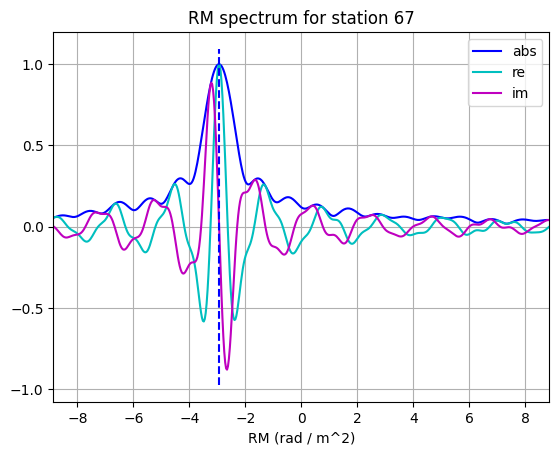

In [8]:
# Fit a rotation measure spectrum for each station Jones.
# Return gaintable filled with pure rotations.

gaintable = model_rotations(gaintable, plot_sample=True).chunk(
    {"frequency": fchunk}
)

In [9]:
# Redo calibration with initial rotation solutions

solver = "normal_equations"
niter = 50
gaintable = run_solver(
    vis=vis,
    modelvis=modelvis,
    gaintable=gaintable,
    solver=solver,
    niter=niter,
    refant=refant,
).load()

# Do some phase referencing for comparisons
inputdata = jones.gain.data * np.exp(
    -1j
    * np.angle(
        jones.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)
finaldata = gaintable.gain.data * np.exp(
    -1j
    * np.angle(
        gaintable.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)

assert np.all(
    np.isclose(finaldata, inputdata, atol=1e-5)
), "Calibration should have converged."

print("done!")

/u/mit183/.pyenv/versions/3.11.7/lib/python3.11/site-packages/ska_sdp_datamodels/visibility/vis_model.py:190: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  return cls(datavars, coords=coords, attrs=attrs)
/u/mit183/.pyenv/versions/3.11.7/lib/python3.11/site-packages/ska_sdp_datamodels/visibility/vis_model.py:190: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly

Could not load dataset for frequency 156 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 157 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 157 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 158 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 159 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 161 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 162 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 163 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 164 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 164 MHz, using the nearest 

2024-12-09 10:37:07,042 - processing_tasks.predict - INFO - Using EveryBeam model in predict
2024-12-09 10:37:07,083 - processing_tasks.predict - INFO - Using EveryBeam model in predict


done!


In [10]:
# Shut down the scheduler and workers
client.close()
client.shutdown()

In [11]:
# On Intel(R) Xeon(R) W-2245 CPU @ 3.90GHz with 8 cores
# Original:
# 64 channels in 16-chan chunks took 29.1 seconds
# 96 channels in  8-chan chunks took 62.7 seconds
# 96 channels in 16-chan chunks took 45.8 seconds
# 96 channels in 24-chan chunks took 39.0 seconds
# 96 channels in 48-chan chunks took 63.4 seconds
# Current
# 96 channels in 16-chan chunks took 49.0 seconds
# 96 channels in 24-chan chunks took 43.0 seconds
# Why is it currently slower?
#  - It appears to be because vis and modelvis were set to persist

dt = timer.perf_counter() - t0
print(f"{nfrequency} channels in {fchunk}-chan chunks took {dt:.1f} seconds")

96 channels in 24-chan chunks took 42.8 seconds
